In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [28]:
# Load Data
df = pd.read_csv('data/Cleaned_Predictive_Data.csv')

df.info()

df

# Feature Selection
X = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
y = df['Target']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

X_train_normal = X_train[~y_train]
X_test_normal = X_test[~y_test]

X_train_fail = X_train[y_train]
X_test_fail = X_test[y_test]

X_normal_tensor = torch.tensor(X_train_normal.values).to(torch.float32)

X_test_normal_tensor = torch.tensor(X_test_normal.values).to(torch.float32)
X_test_fail_tensor = torch.tensor(X_test_fail.values).to(torch.float32)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9973 entries, 0 to 9972
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      9973 non-null   float64
 1   Process temperature [K]  9973 non-null   float64
 2   Rotational speed [rpm]   9973 non-null   float64
 3   Torque [Nm]              9973 non-null   float64
 4   Tool wear [min]          9973 non-null   float64
 5   Target                   9973 non-null   int64  
 6   Type_H                   9973 non-null   bool   
 7   Type_L                   9973 non-null   bool   
 8   Type_M                   9973 non-null   bool   
dtypes: bool(3), float64(5), int64(1)
memory usage: 496.8 KB


In [29]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(5, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 5)
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

In [ ]:
learning_rate = 1e-3
model = Autoencoder()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
epochs = 10
batch_size = 1

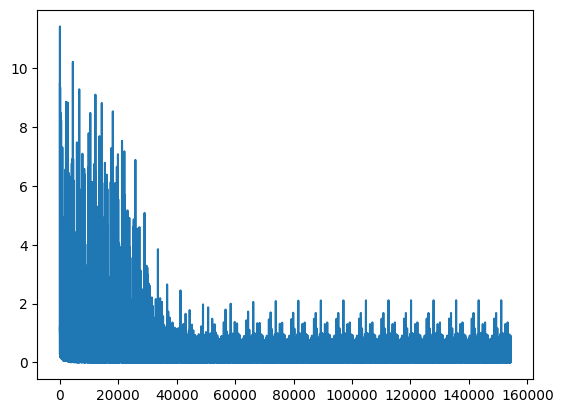

In [31]:
# Model training
loss_values = []
model.train

for epoch in range(epochs):
    for i in range(0, len(X_normal_tensor), batch_size):
        # Pass only normal
        reconst = model(X_normal_tensor[i:i+batch_size])
        loss = loss_fn(reconst, X_normal_tensor[i:i+batch_size])

        # Back propagate
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Keep track of loss
        loss_values.append(loss.item())

        print('Epoch {0} Step {1}: Loss - {2}'.format(epoch+1, i+1, loss.item()), end='\r')

plt.plot(loss_values)
plt.show()


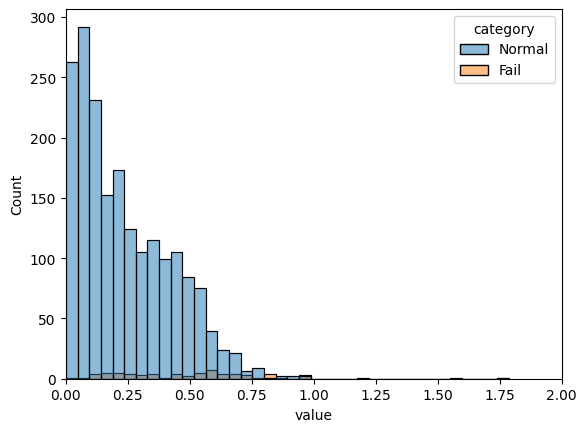

In [32]:
# Model evaluation
model.eval()

normal_loss = []
fail_loss = []

losses = []

for i in range(len(X_test_normal_tensor)):
    with torch.no_grad():
        reconst = model(X_test_normal_tensor[i])
        loss = loss_fn(reconst, X_test_normal_tensor[i])

        normal_loss.append(loss.item())
        losses.append({
            'y_true': 0,
            'error': loss.item()
        })
for i in range(len(X_test_fail_tensor)):
    with torch.no_grad():
        reconst = model(X_test_fail_tensor[i])
        loss = loss_fn(reconst, X_test_fail_tensor[i])

        fail_loss.append(loss.item())
        losses.append({
            'y_true': 1,
            'error': loss.item()
        })

df_normal = pd.DataFrame(normal_loss, columns=['value'])
df_fail = pd.DataFrame(fail_loss, columns=['value'])

df_normal['category'] = 'Normal'
df_fail['category'] = 'Fail'

df_test = pd.concat([df_normal, df_fail])

sns.histplot(data=df_test, x='value', hue='category')
plt.xlim([0, 2])

df_recon = pd.DataFrame(losses)


In [33]:
# Threshold Tuning
def threshold_tuning(df, iterations):
    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1-score': []
    }

    for i in range(iterations):
        threshold = df['error'].quantile(i/iterations)
        preds = df['error'] > threshold
        cr = classification_report(df['y_true'], preds, output_dict=True)

        thresh_df['threshold'].append(threshold)
        thresh_df['accuracy'].append(cr['accuracy'])
        thresh_df['precision'].append(cr['macro avg']['precision'])
        thresh_df['recall'].append(cr['macro avg']['recall'])
        thresh_df['f1-score'].append(cr['macro avg']['f1-score'])
    
    return pd.DataFrame(thresh_df)

thresh_df = threshold_tuning(df_recon, 10)
optimal_threshold = thresh_df[thresh_df['accuracy'] == thresh_df['accuracy'].max()]
threshold = optimal_threshold['threshold'].values[0]
print(f'Threshold with maximum accuracy: {threshold:.6f}\nAccuracy: {optimal_threshold['accuracy'].values[0]:.6f}')



Threshold with maximum accuracy: 0.525400
Accuracy: 0.898246


              precision    recall  f1-score   support

           0       0.98      0.91      0.95      1926
           1       0.17      0.48      0.25        69

    accuracy                           0.90      1995
   macro avg       0.57      0.70      0.60      1995
weighted avg       0.95      0.90      0.92      1995



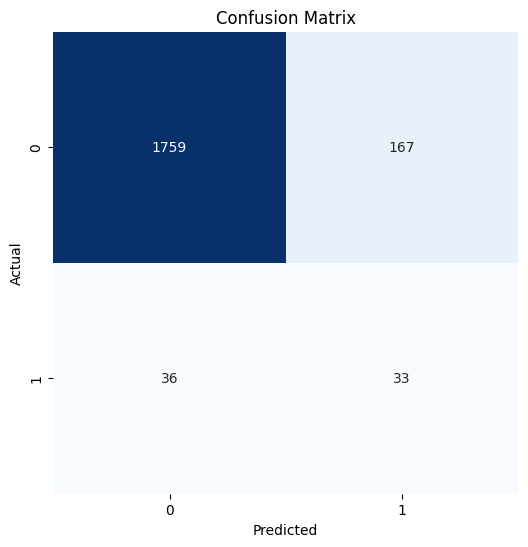

In [34]:
# Results
df_recon['y_pred'] = df_recon['error'] > threshold
print(classification_report(df_recon['y_true'], df_recon['y_pred']))
cm = confusion_matrix(df_recon['y_true'], df_recon['y_pred'])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save
torch.save(model.state_dict(), 'output/autoencoder.pth')